In [53]:
import random
import numpy as np
import matplotlib.pyplot as plt

from numpy import pi as π

import perceval as pv
from scipy.optimize import minimize
from perceval.components import *

from collections import Counter

from submission.circuits import fullCircuit
import matplotlib.pyplot as plt

In [54]:
# Fraction of [1, 0, x, y] states
def getFidelityRho1(counts):
    totCounts, validCounts = 0, 0

    for state in counts:
        totCounts += counts[state]
        if state[0] == 1 and state[1] == 0:
            validCounts += counts[state]

    return validCounts/totCounts


# Fraction of [x, y, 1, 0] states
def getFidelityRho2(counts):
    totCounts, validCounts = 0, 0

    for state in counts:
        totCounts += counts[state]
        if state[2] == 1 and state[3] == 0:
            validCounts += counts[state]

    return validCounts/totCounts

def getFidelities(counts):
    return (getFidelityRho1(counts), getFidelityRho2(counts))

def costFunctionAtPhi(counts):
    return (1 - getFidelityRho1(counts))**2 + (1 - getFidelityRho2(counts))**2 + (getFidelityRho1(counts)-getFidelityRho2(counts))**2

In [55]:
def computeFidelity(x0, testPhi = π/2):

    circuit = fullCircuit(theta_params=x0, prepTheta=π/2, prepPhi=testPhi)

    p = pv.Processor("SLOS", circuit)
    p.with_input(pv.BasicState([0, 1, 0, 1]))

    # The sampler holds 'probs', 'sample_count' and 'samples' calls. You can use the one that fits your needs!
    sampler = pv.algorithm.Sampler(p)  
    sample_count = sampler.sample_count(1000)['results']
    
    valid_counts = {}
    for c in sample_count:
        if c[0] != c[1] and c[2] != c[3]: #Since we introduce only 2 photons in the circuit it is enough
            valid_counts[c] = sample_count[c]

    # print(valid_counts)
    fr1 = getFidelityRho1(valid_counts)
    fr2 = getFidelityRho2(valid_counts)

    # print(fr1)
    # print(fr2)

    return fr1, fr2

In [56]:
def loss_function(theta = [0] * 12):
    cost = 0
    Phi = [ 0, π/2, π, 3*π/2 ]

    # Evaluate the 4 cost functions, one for each fidelity
    for phi_i in Phi:
        circuit = fullCircuit(theta_params=theta, prepTheta=π/2, prepPhi=phi_i)
        p = pv.Processor("SLOS", circuit)
        p.with_input(pv.BasicState([0, 1, 0, 1]))

        # The sampler holds 'probs', 'sample_count' and 'samples' calls. You can use the one that fits your needs!
        sampler = pv.algorithm.Sampler(p)  
        sample_count = sampler.sample_count(1000)['results']

        valid_counts = {}
        for c in sample_count:
            if c[0] != c[1] and c[2] != c[3]: #Since we introduce only 2 photons in the circuit it is enough
                valid_counts[c] = sample_count[c]
        
        cost += costFunctionAtPhi(valid_counts)
        
    return cost

In [57]:
def optimCallback(intermediate_result):
    
    outLine = f'{intermediate_result.fun:0.3f}, '
    for x in intermediate_result.x:
        outLine += f'{x}, '
    outLine += '\n'

    print(outLine)
    with open('ResultFile.csv', 'a+') as outFile:
        outFile.writelines([outLine])

In [58]:
class ao():
    def __init__(self, x0):
        self.x = x0

def minimizeVal(swapMimimizers, x0 = None, maxIter = 100):
    res = ao((np.random.rand(1, 12)[0])*2*π) if x0 == None else ao(x0)

    print(res.x)

    with open('ResultFile.csv', 'w') as outFile:
        outFile.writelines('Fun, p0, p1, p2, p3, p4, p5, p6, p7, p8, p9, p10, p11')

    for minimizerSwapIndex in range(swapMimimizers):
        res = minimize(loss_function,
            res.x,
            method="Nelder-Mead",
            bounds=[(0, 2*π)]*12,
            callback=optimCallback,
            options={'maxiter':maxIter}
        )
        optimCallback(res)


        res = minimize(loss_function,
            res.x,
            method="powell",
            bounds=[(0, 2*π)]*12,
            callback=optimCallback
        )
        optimCallback(res)


    return res

In [59]:
res = minimizeVal(20)

[3.49045211 1.48289133 0.84126604 2.34790797 4.21345502 1.41047151
 0.20862424 0.75581076 4.33931494 3.72784981 0.84985001 5.14131289]
2.241, 3.490452112651454, 1.482891328200033, 0.8412660395795754, 2.3479079701524594, 4.213455021106661, 1.4104715130598497, 0.2086242394668379, 0.7558107570864195, 4.339314937709711, 3.7278498091351713, 0.8923425080736584, 5.141312887281844, 

2.241, 3.490452112651454, 1.482891328200033, 0.8412660395795754, 2.3479079701524594, 4.213455021106661, 1.4104715130598497, 0.2086242394668379, 0.7558107570864195, 4.339314937709711, 3.7278498091351713, 0.8923425080736584, 5.141312887281844, 

2.241, 3.490452112651454, 1.482891328200033, 0.8412660395795754, 2.3479079701524594, 4.213455021106661, 1.4104715130598497, 0.2086242394668379, 0.7558107570864195, 4.339314937709711, 3.7278498091351713, 0.8923425080736584, 5.141312887281844, 

2.241, 3.490452112651454, 1.482891328200033, 0.8412660395795754, 2.3479079701524594, 4.213455021106661, 1.4104715130598497, 0.2086242

In [60]:
computeFidelity(res.x)

(0.6804878048780488, 0.8658536585365854)

In [61]:
import csv

Min cost: 0.004 


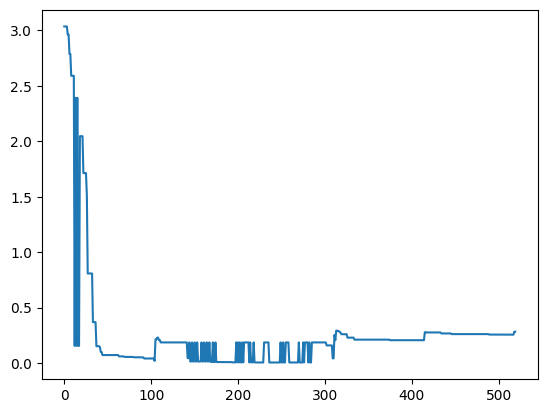

In [62]:
with open('ResultFile.csv', newline='') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
    next(spamreader)
    costs = []
    minCost = 10
    minConfig = []
    for row in spamreader:
        costs.append(float(row[0]))
        if costs[-1] < minCost:
            minCost = costs[-1]
            minConfig = [float(el) for el in row[1:13]]
        
plt.plot(costs)
print(f'Min cost: {minCost} ')

Average fidelity of 1st clone: 48.361%
Average fidelity of 2nd clone: 95.813%



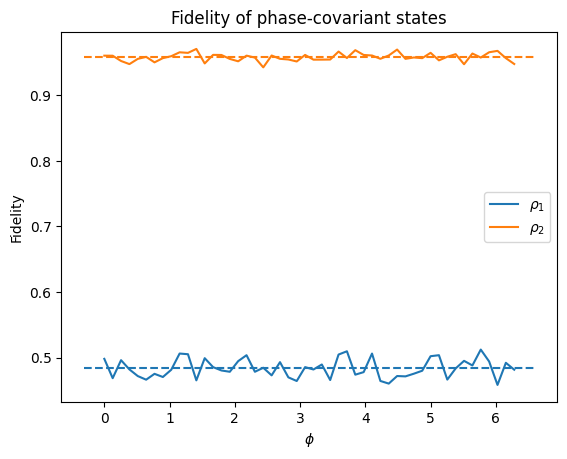

In [63]:
phi = np.linspace(0, 2*π, 50)
fid = []

for phi_i in phi:
    fid.append(computeFidelity(minConfig))

avgFidelity = [ np.mean([ fid[i][cloneIndex] for i in range(len(fid)) ]) for cloneIndex in range(2)]

print(f'Average fidelity of 1st clone: {100*avgFidelity[0]:.3f}%')
print(f'Average fidelity of 2nd clone: {100*avgFidelity[1] :.3f}%')

print()
plt.plot(phi, fid)
plt.hlines(avgFidelity, *plt.xlim(), colors=["#1f77b4", "#ff7f0e"], linestyles='--')
plt.xlabel('$\phi$')
plt.ylabel('Fidelity')

plt.title('Fidelity of phase-covariant states')
plt.legend([r'$\rho_1$', r'$\rho_2$'])
plt.show()